In [1]:
import data
import models
import cache
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import logging
cache_logger = logging.getLogger('cache')
cache_logger.setLevel(logging.DEBUG)

In [3]:
sns.set(context='talk')

In [4]:
by = 'cell_type'
sample_n = 500
model_name = 'model4'

## load data for a sample of genes

In [5]:
sample_df = cache.cached(models.prep_sample_df, sample_n=sample_n)

INFO:cache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_500.pkl
DEBUG:cache:prep_sample_df: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/prep_sample_df.cached.sample_n_500.pkl
INFO:cache:prep_sample_df: Loading result from cache


## fit model

In [6]:
stan_data = models.prep_stan_data(sample_df, by=by)

In [7]:
model_file = models.get_model_file(model_name='model4')
print(cache._read_file(model_file))

## try neg binom parameterization
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta; // loading factors for each gene, for each cell type
    vector[G] log_gene_base;

In [8]:
model_fit = models.cached_stan_fit(file=model_file, data=stan_data, model_name=model_name)

INFO:cache:Step 1: Get compiled model code, possibly from cache
INFO:cache:StanModel: cache_filename set to model4.cython_0_25_1.model_code_35447780597.pystan_2_12_0_0.stanmodel.pkl
DEBUG:cache:StanModel: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/model4.cython_0_25_1.model_code_35447780597.pystan_2_12_0_0.stanmodel.pkl
INFO:cache:StanModel: Loading result from cache
INFO:cache:Step 2: Get posterior draws from model, possibly from cache
INFO:cache:sampling: cache_filename set to model4.cython_0_25_1.model_code_35447780597.pystan_2_12_0_0.stanfit.chains_4.data_40479835703.iter_2000.seed_1245502385.pkl
DEBUG:cache:sampling: cache_filepath set to /home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/.cached_models/model4.cython_0_25_1.model_code_35447780597.pystan_2_12_0_0.stanfit.chains_4.data_40479835703.iter_2000.seed_1245502385.pkl
INFO:cache:sampling: Loading result from ca

## check convergence (superficially)

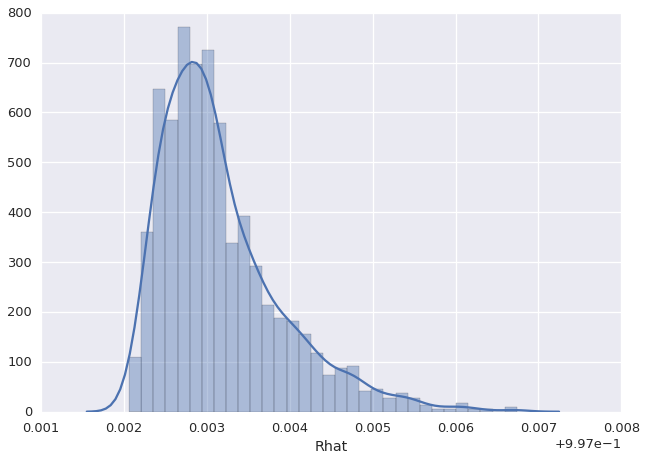

In [9]:
models.plot_stan_summary(model_fit, pars='theta', metric='Rhat')

In [10]:
models.print_stan_summary(model_fit, pars='lp__')

              mean   se_mean         sd          2.5%           50%         97.5%      Rhat
lp__  7.976705e+07  0.911986  36.376698  7.976698e+07  7.976705e+07  7.976712e+07  0.999749


## summarize posterior draws of theta by gene

In [9]:
# meta-data used for plotting functions below
# so that the following code is invariant to the model run
colnames = list(stan_data['x'].columns)
sort_by = colnames[0]
print(sort_by)

cell_type[B]


In [10]:
theta_ldf = models.prep_theta_summary(model_fit, sample_df=sample_df, colnames=colnames, expose_group=sort_by)

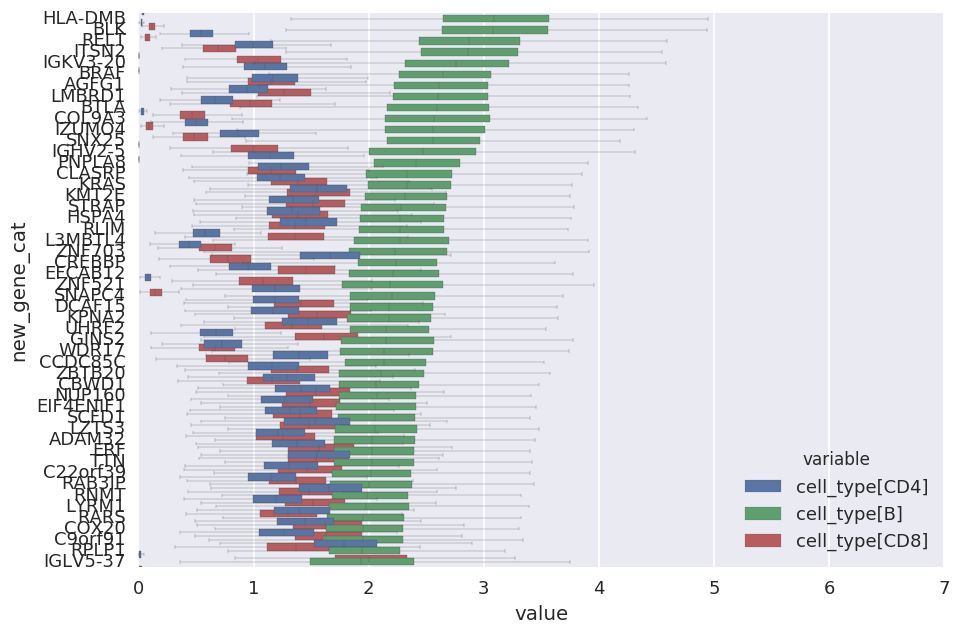

In [11]:
## show theta estimates for first 50 genes, by `sort-by`
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

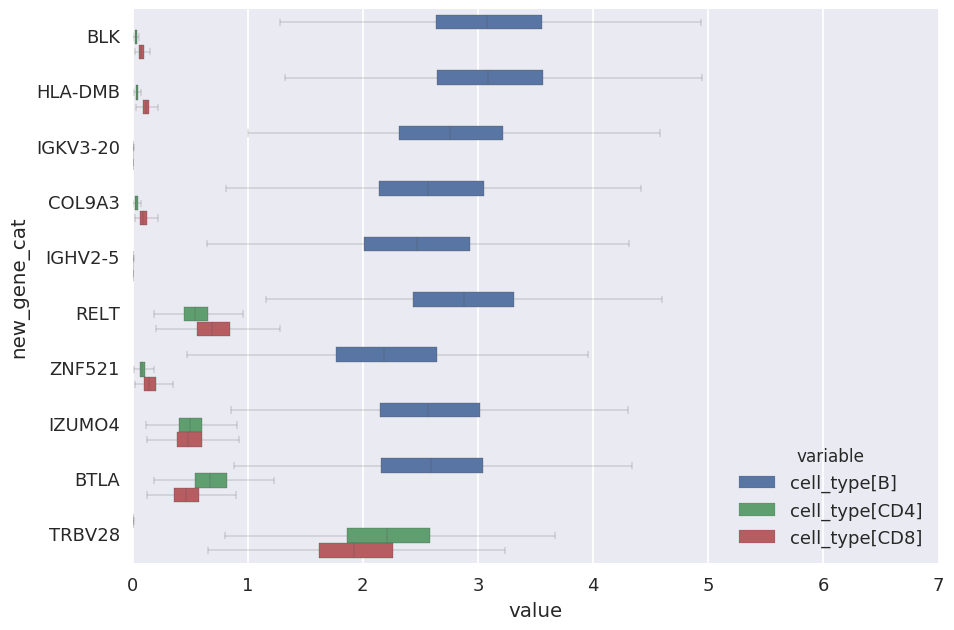

In [12]:
## zoom in on the highest-ranked genes by `sort-by` difference from average 
## across all cell types
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

## posterior-predictive checking for selected genes

In [13]:
# identify top_genes by name
top_genes = theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .drop_duplicates(subset='new_gene_cat')['new_gene_cat'].values
print(top_genes)

['BLK' 'BTLA' 'COL9A3' 'HLA-DMB' 'IGHV2-5' 'IGKV3-20' 'IZUMO4' 'RELT'
 'TRBV28' 'ZNF521']


In [14]:
# get yrep draws
yrep_df = models.prep_yrep_summary(model_fit, sample_df=sample_df, filter_genes=top_genes[0:3])

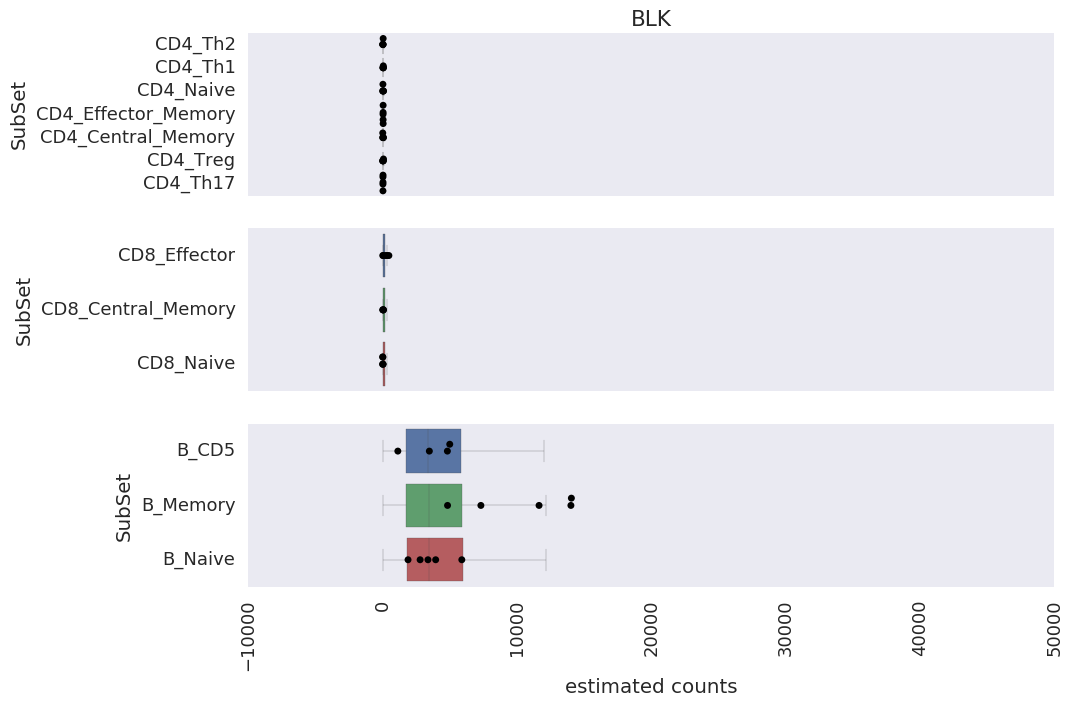

In [15]:
# plot estimates & observed values for top 3 genes, by Subset
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=top_genes, sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=1)


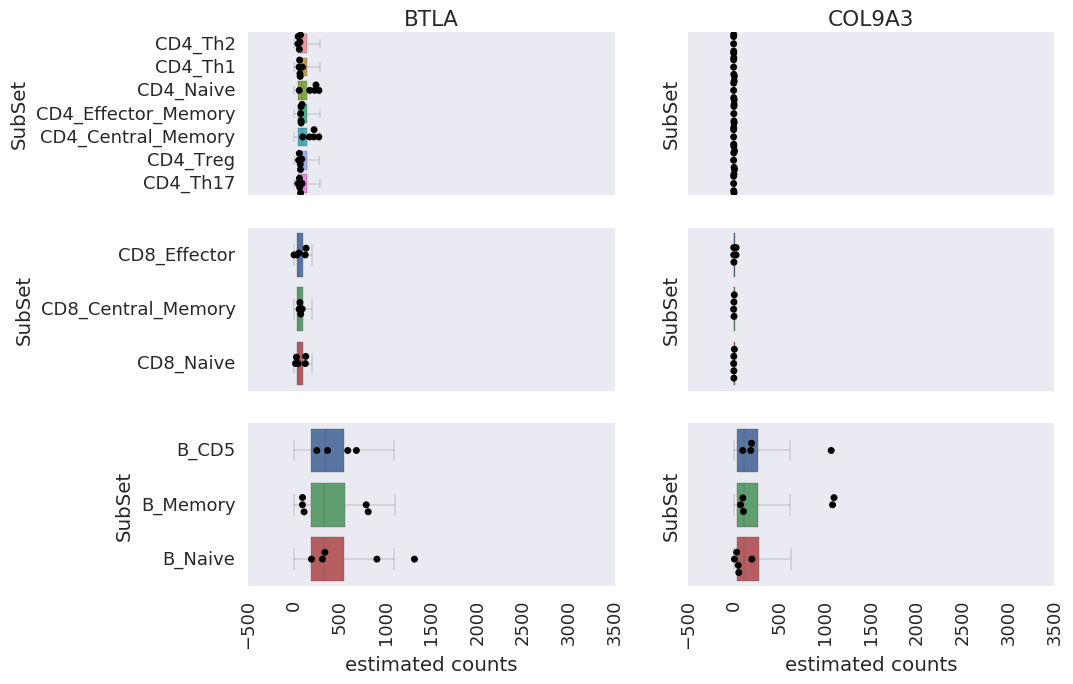

In [16]:
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=top_genes[1:], sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=2)